In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-06-30 15:35:23,757 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
ri = hardware_tools.r2_with_mk1()

INFO     2016-06-30 15:35:25,247 - kid_readout.roach.interface.initialize:417  Loaded ROACH state from /data/readout/r2kid_config.npz


In [7]:
np.arange(1,9)*24

array([ 24,  48,  72,  96, 120, 144, 168, 192])

In [23]:
ri.is_roach2

True

In [19]:
def measure_hardware_delay(ri,frequencies=np.arange(1,9)*24,num_tone_samples=2**16,num_points=16,make_plots=False):
    offsets = np.arange(-num_points//2,num_points//2+1)*ri.fs/float(num_tone_samples)
    sa = acquire.run_sweep(ri,ri.lo_frequency+frequencies[None,:]+offsets[:,None],num_tone_samples=num_tone_samples,verbose=True)
    print np.median(np.abs(sa.s21_point))
    local_delays = []
    for k in range(frequencies.shape[0]):
        swp = sa.sweep(k)
        deltaf = swp.frequency-swp.frequency.min() 
        phase = np.unwrap(np.angle(swp.s21_point))
        rad_per_Hz,offset = np.polyfit(deltaf,phase,1)
        local_delays.append(rad_per_Hz/(2*np.pi))
        if make_plots:
            plot(deltaf,phase-offset,'.')
            plot(deltaf,rad_per_Hz*deltaf)
            xlabel('Offset Frequency (Hz)')
            ylabel('Phase (rad)')
    local_delays = np.array(local_delays)
    if make_plots:
        figure()
        plot(frequencies,local_delays*1e9,'o')
        axhline(np.median(local_delays*1e9),linestyle='--',color='r')
        xlabel('Measurement Frequency (MHz)')
        ylabel('Delay (ns)')
    logger.debug("median local delay: %.1f ns" % (np.median(local_delays)*1e9))
    frequency = sa.frequency
    deltaf = frequency - frequency.min()
    phase = np.unwrap(np.angle(sa.s21_point*np.exp(-1j*np.median(local_delays)*2*np.pi*deltaf)))
    rad_per_Hz,offset = np.polyfit(deltaf,phase,1)
    if make_plots:
        figure()
        plot(frequency/1e6,phase,'.')
        plot(frequency/1e6,offset+rad_per_Hz*deltaf)
        xlabel('Frequency (MHz)')
        ylabel('Phase (rad)')
    total_delay = np.median(local_delays) + rad_per_Hz/(2*np.pi)
    logger.debug("residual delay %.1f ns global delay = %.1f ns" % (1e9*rad_per_Hz/(2*np.pi), 1e9*total_delay))
    return total_delay


In [5]:
logger.setLevel(logging.DEBUG)

In [9]:
ri.set_loopback(False)
ri.set_fft_gain(8)

In [14]:
ri.demodulator.hardware_delay_samples=-16025.6-223.82740770179902

In [8]:
#ri.demodulator.hardware_delay_samples=-16360

In [16]:
_*512e6

-19.926603882815446

 Measuring bank
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

DEBUG    2016-06-30 15:43:50,067 - kid_readout.measure_hardware_delay:24  median local delay: -44.5 ns
DEBUG    2016-06-30 15:43:50,107 - kid_readout.measure_hardware_delay:36  residual delay 0.8 ns global delay = -43.7 ns


 661.718


-4.3690844073264241e-08

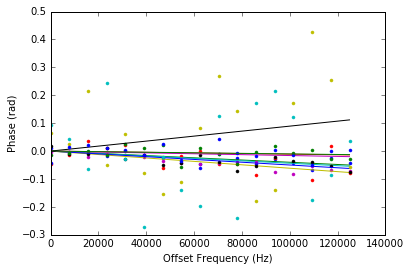

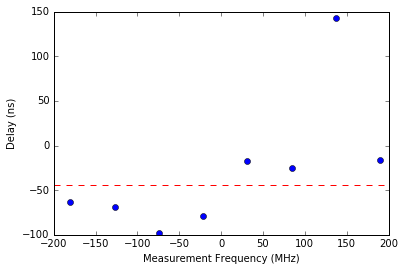

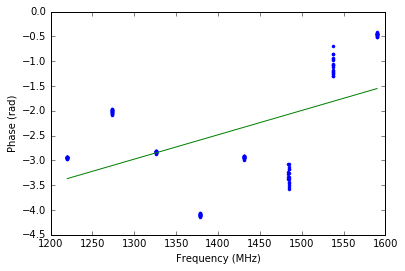

In [22]:
measure_hardware_delay(ri,frequencies=np.linspace(-180,190,8),make_plots=True)